In [1]:
import scipy.io as sio
import numpy as np
import torch
import os
from os import listdir
from os.path import isfile, join
from torch import nn, optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np 
import math
import pandas as pd
import cmath
import scipy.io as sio
import numpy as np
import torch
from torch import nn, optim
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np 
import math
import pandas as pd
import cmath

#from unet import UNet
# from auto import encoder, decoder

from collections import OrderedDict
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
#==========================================================================
# For Plotting loss graph
# Bokeh
from bokeh.io import curdoc
from bokeh.layouts import column
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure

from functools import partial
from threading import Thread
from tornado import gen
# from AttRCNN_UNet import Att_R2U
import logging
logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)
import sys
# from dataloader import norm
import csv
from sklearn.model_selection import train_test_split
from sys import getsizeof
# import wandb
# import logging
# logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)

In [2]:
nq_type = "SNS" # Sub-Nyquist or Nyquist sample
no_samples = 200
no_doa = 1

In [3]:
root_dataset_path =  ("../../SNS_dataset/200/DOA1")

In [4]:
def create_dataset(df, dataset_type):
  
    data = np.transpose(df[dataset_type], (2, 0, 1))
    label = df['DOA']
    X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.10, random_state=42)
    
    return X_train, X_test, y_train, y_test

In [5]:
def get_data(train, label, batch_size, train_bool=True):
    class DOA_dataset(Dataset):
        def __init__(self, train, test):
            self.x = torch.from_numpy(np.array(train))
            self.y = torch.from_numpy(np.asarray(label))
            self.n_sample = len(self.y)
        def __getitem__(self, index):
            return self.x[index], self.y[index]
        def __len__(self):
            return self.n_sample


    dataset = DOA_dataset(train, label)
    

    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=train_bool)
    return loader

In [6]:
def create_dataloader(root_path, dataset_type, ss):
    # Loading all dataset 
    logging.info('Data prepration started')
    df1  = sio.loadmat(root_path + "/SNR_{}_0_{}_{}.mat".format(nq_type, no_doa, no_samples))
    df2  = sio.loadmat(root_path + "/SNR_{}_10_{}_{}.mat".format(nq_type, no_doa, no_samples))
    df3  = sio.loadmat(root_path + "/SNR_{}_20_{}_{}.mat".format(nq_type, no_doa, no_samples))
    df4  = sio.loadmat(root_path + "/SNR_{}_30_{}_{}.mat".format(nq_type, no_doa, no_samples))
    df5  = sio.loadmat(root_path + "/SNR_{}_40_{}_{}.mat".format(nq_type, no_doa, no_samples))
#     df1  = sio.loadmat("../../SNS_dataset/200/DOA1/SNR_SNS_00_1.mat")
#     df2  = sio.loadmat("../../SNS_dataset/200/DOA1/SNR_SNS_10_1.mat")
#     df3  = sio.loadmat("../../SNS_dataset/200/DOA1/SNR_SNS_20_1.mat")
#     df4  = sio.loadmat("../../SNS_dataset/200/DOA1/SNR_SNS_30_1.mat")
#     df5  = sio.loadmat("../../SNS_dataset/200/DOA1/SNR_SNS_40_1.mat")
    df = [df1, df2, df3, df4, df5]

    new_train_dataset_list = []
    new_test_dataset_list = []
    train_dataset_list_label = []
    test_dataset_list_label = []

    dataset_len = 0
    if dataset_type == "SNS":
        dataset_len = ss//10
    if dataset_type == "NS":
        dataset_len = ss

    for file in df:
        X_train, X_test, y_train, y_test = create_dataset(file, dataset_type+"_data")
        new_train_dataset_list.extend(X_train)
        new_test_dataset_list.append(X_test.tolist())
        train_dataset_list_label.extend(y_train)
        test_dataset_list_label.append(y_test.tolist())

    # Deleteing all unused memory
    del df

    # Dividing into different channels
    logging.info('Dividing your dataset into 3 channel')

    for idx, data in enumerate(new_train_dataset_list):
        new = np.zeros((3, 8, dataset_len))
        for j in range(0, data.shape[0]):
            for k in range(0, data.shape[1]):
                new[0][j][k] = data[j][k].real
                new[1][j][k] = data[j][k].imag
                new[2][j][k] = cmath.phase(data[j][k])
        new_train_dataset_list[idx] = new

    for idx, data in enumerate(new_test_dataset_list):
        for i, ndata in enumerate(data):
            new = np.zeros((3, 8, dataset_len))
            for j in range(0, 8):
                for k in range(0, dataset_len):
                    new[0][j][k] = ndata[j][k].real
                    new[1][j][k] = ndata[j][k].imag
                    new[2][j][k] = cmath.phase(ndata[j][k])
            new_test_dataset_list[idx][i] = new

    # Generaring train loader
    logging.info('Creating Train dataloader')
    doa_train_loader = get_data(new_train_dataset_list, train_dataset_list_label, 64, True)

    # Deleteing all unused memory
    del new_train_dataset_list
    del train_dataset_list_label

    test_dataset_list = []
    logging.info('Creating Validation dataloader')
    for idx, data in enumerate(new_test_dataset_list):
        f = get_data(data, test_dataset_list_label[idx], 128, False)
        test_dataset_list.append(f)

    # Deleteing all unused memory
    del new_test_dataset_list
    del new
    logging.info('Your dataset is ready !!')
    return doa_train_loader ,test_dataset_list

In [7]:
doa_train_loader , test_dataset_list = create_dataloader(root_dataset_path, "SNS", 200)

2021-07-02 15:09:38,200 - Data prepration started
2021-07-02 15:11:35,643 - Dividing your dataset into 3 channel
2021-07-02 15:14:38,575 - Creating Train dataloader
2021-07-02 15:14:39,718 - Creating Validation dataloader
2021-07-02 15:14:39,809 - Your dataset is ready !!


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=(3,3), stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=(3,3), stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.relu2 = nn.ReLU(inplace=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu2(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=181):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=(1,3), stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=1)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=1)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=1)
        self.linear = nn.Linear(25, num_classes)
        self.adp_pool = nn.AdaptiveMaxPool2d((no_doa, 25))
        #self.flat = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1)
        self.flat = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1)
        self.dropout = nn.Dropout(0.9)
        self.dropout1 = nn.Dropout(0.8)
        self.relu = nn.ReLU(inplace=True)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.dropout(out)
        out = self.layer4(out)
        out = self.dropout1(out)
        out = self.adp_pool(out)
        out = self.linear(out)
        out = self.dropout1(out)
        out = self.flat(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [2, 3, 5, 2])

def ResNet101():
    return ResNet(BasicBlock, [3, 4, 23, 3])


if __name__ == "__main__":
    image = torch.rand(1, 3, 10, 100)
    model = ResNet34()
    print(model(image).size())


torch.Size([1, 1, 1, 181])


In [9]:
class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, gamma=2,reduction='mean'):
        super(FocalLoss, self).__init__(weight,reduction=reduction)
        self.gamma = gamma
        self.weight = weight #weight parameter will act as the alpha parameter to balance class weights

    def forward(self, input, target):
        ce_loss = F.cross_entropy(input, target,reduction=self.reduction,weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

In [10]:
num_epochs = 70

weights_dir = "../doa_weights"

autoencoder = ResNet34()
cross_criterion = nn.CrossEntropyLoss()
focal_criterion = FocalLoss()
# if ('{}_DOA_{}_{}_model.pth'.format(nq_type, no_doa, no_samples) in [f for f in listdir(weights_dir) if isfile(join(weights_dir, f))]):
#     print("Pre-trained available for DOA_{}_{}_model.pth".format(no_doa, no_samples))
#     autoencoder = torch.load(os.path.join(weights_dir, '{}_DOA_{}_{}_model.pth'.format(nq_type, no_doa, no_samples)))

# model = nn.Sequential( pre_trained, autoencoder)
# model = ConvAutoencoder()
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
    classification_model = autoencoder.cuda()
    optimizer = optim.AdamW(classification_model.parameters(), lr=0.001, weight_decay=1e-3)
  
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", factor=0.05, patience=3, verbose=True)

GeForce GTX 1080 Ti


In [11]:
acc_res = {
    "training": [],
    0: [],
    10: [],
    20: [],
    30: [],
    40: []
}
loss_res = {
    "training": [],
    0: [],
    10: [],
    20: [],
    30: [],
    40: []
}
mae_res = {
    "training": [],
    0: [],
    10: [],
    20: [],
    30: [],
    40: []
}

In [12]:
%%time
def train():
    print("Training Starts !!!!!!!")
    best_valid_loss = float('Inf')
    for i in range(num_epochs):
        training_loss = 0
        train_correct = 0
        train_total = 0
        epoch_loss = 0.0
        training_mae = 0.0
        classification_model.train()
        criterion = None
        if (i+1)>=25 :
          print("Criterion is changed to focal loss")
          criterion = focal_criterion.cuda()
        else:
          criterion = cross_criterion.cuda()
        for j,(features, labels) in enumerate(doa_train_loader, 0):
            features, labels = Variable(features.cuda()), Variable(labels.cuda())
            optimizer.zero_grad()
            enn = classification_model(features.float())
            auto_outputs = torch.transpose(enn, 2, 3)
            auto_outputs = torch.reshape(auto_outputs.cuda(), (auto_outputs.shape[0], 181, no_doa))
            losss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())
            losss.backward()
            optimizer.step()
#           exp_scheduler.step()
            training_loss += losss.item()

            _, pred = torch.max(auto_outputs, 1)

            train_total+= labels.reshape(-1).size(0)

            train_correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()

            epoch_loss += auto_outputs.shape[0] * losss.item()
            training_mae += torch.mean(torch.abs(pred.float().cuda() - labels.float()))

        loss_res['training'].append(training_loss/len(doa_train_loader))
        acc_res['training'].append((100*(train_correct/train_total)))
        mae_res['training'].append(training_mae/(len(doa_train_loader)*181))
        print('Epoch [{}/{}], Training Loss: {:.4f}, Training Accuracy: {:.4f}, Training MAE: {}'
                      .format(i+1, num_epochs, training_loss/len(doa_train_loader), (100*(train_correct/train_total)), training_mae/(len(doa_train_loader)*181)))
        
        # Validation for each SNR value
        classification_model.eval()
        total_valdation_loss = 0
        zero_val = 0
        for val_data in range(0, len(test_dataset_list)):
            
            validation_loss = 0
            validation_acc = 0
            validation_mae = 0.0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for features, labels in test_dataset_list[val_data]:
                    features, labels = Variable(features.cuda()), Variable(labels.cuda())
                    enn = classification_model(features.float())
                    auto_outputs = torch.transpose(enn, 2, 3)
                    auto_outputs = torch.reshape(auto_outputs, (auto_outputs.shape[0], 181, no_doa))
                    loss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())

                    _, pred = torch.max(auto_outputs, 1)
                    val_total+= labels.reshape(-1).size(0)
                    val_correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
                    validation_loss += loss.item()
                    validation_mae += torch.mean(torch.abs(pred.float().cuda() - labels.float()))

                loss_res[10*val_data].append(validation_loss/len(test_dataset_list[val_data]))
                acc_res[10*val_data].append((100*(val_correct/val_total)))
                
                mae_res[10*val_data].append(validation_mae/(len(test_dataset_list[val_data])*181))
                print('SNR [{}dB], Validation Loss: {:.4f}, Validation Accuracy: {:.4f}, Validation MAE: {}'
                      .format(val_data*10, validation_loss/len(test_dataset_list[val_data]), (100*(val_correct/val_total)), validation_mae/(len(test_dataset_list[val_data])*181)))

                total_valdation_loss+=validation_loss

        scheduler.step(loss_res[0][len(loss_res[0])-1])
        # print("Odb Loss => ", loss_res[0][len(loss_res[0])-1])
        # print("Lr -> ", optimizer.state_dict()["param_groups"][0]['lr'])
        torch.save( classification_model, weights_dir+ "/{}_DOA_{}_{}_model.pth".format(nq_type, no_doa, no_samples))
        if best_valid_loss > total_valdation_loss:
            best_valid_loss = total_valdation_loss 
            # Saving Best Pre-Trained Model as .pth file
            torch.save( classification_model, weights_dir+ "/{}_DOA_{}_{}_best_model.pth".format(nq_type, no_doa, no_samples))
#         if i%10 == 0:
#           ddf = pd.DataFrame(acc_res)
#           ddf.to_csv(weights_dir+"res_DOA_{}_model.csv".format(doa))
        print("\n")

train()
print("Training Complete")

Training Starts !!!!!!!
Epoch [1/70], Training Loss: 2.3957, Training Accuracy: 31.8562, Training MAE: 0.07680299133062363
SNR [0dB], Validation Loss: 3.9680, Validation Accuracy: 10.1500, Validation MAE: 0.23063567280769348
SNR [10dB], Validation Loss: 2.9820, Validation Accuracy: 33.7800, Validation MAE: 0.17167066037654877
SNR [20dB], Validation Loss: 2.6311, Validation Accuracy: 46.1400, Validation MAE: 0.14875385165214539
SNR [30dB], Validation Loss: 2.5886, Validation Accuracy: 47.5100, Validation MAE: 0.14894288778305054
SNR [40dB], Validation Loss: 2.5708, Validation Accuracy: 49.4600, Validation MAE: 0.14388954639434814


Epoch [2/70], Training Loss: 1.0235, Training Accuracy: 64.1571, Training MAE: 0.029807673767209053
SNR [0dB], Validation Loss: 3.8276, Validation Accuracy: 9.9000, Validation MAE: 0.2464590072631836
SNR [10dB], Validation Loss: 2.6455, Validation Accuracy: 38.0100, Validation MAE: 0.168590247631073
SNR [20dB], Validation Loss: 2.0867, Validation Accuracy: 55

KeyboardInterrupt: 

In [13]:
# SNS DOA-2 200 Samples
print("=== Metrics ===")
print("==== DOA-{} ====".format(no_doa))
print("= MAE =_= Acc =")
print("{:.4f}".format(min(mae_res[0])), "  {:.2f}".format(acc_res[0][mae_res[0].index(min(mae_res[0]))]))
print("{:.4f}".format(min(mae_res[10])), "  {:.2f}".format(acc_res[10][mae_res[10].index(min(mae_res[10]))]))
print("{:.4f}".format(min(mae_res[20])), "  {:.2f}".format(acc_res[20][mae_res[20].index(min(mae_res[20]))]))
print("{:.4f}".format(min(mae_res[30])), "  {:.2f}".format(acc_res[30][mae_res[30].index(min(mae_res[30]))]))
print("{:.4f}".format(min(mae_res[40])), "  {:.2f}".format(acc_res[40][mae_res[40].index(min(mae_res[40]))]))

=== Metrics ===
==== DOA-1 ====
= MAE =_= Acc =
0.0599   35.24
0.0222   73.17
0.0123   89.96
0.0083   95.89
0.0032   99.00


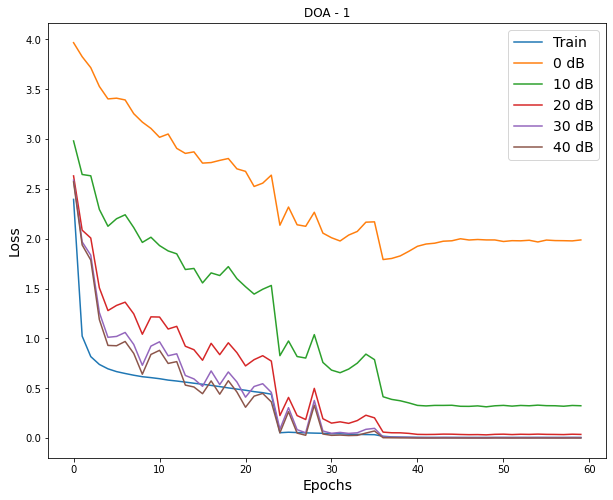

In [14]:
import matplotlib.pyplot as plt
ep = range(0, len(loss_res["training"]))
plt.figure(figsize=(10, 8))
plt.plot(ep, loss_res["training"], label='Train')
plt.plot(ep, loss_res[0], label='0 dB')
plt.plot(ep, loss_res[10], label='10 dB')
plt.plot(ep, loss_res[20], label='20 dB')
plt.plot(ep, loss_res[30], label='30 dB')
plt.plot(ep, loss_res[40], label='40 dB')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title("DOA - {}".format(no_doa))
plt.legend(fontsize=14)
plt.show()

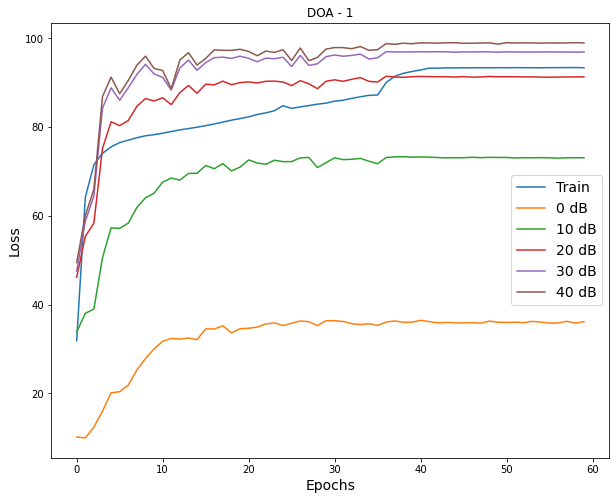

In [15]:
import matplotlib.pyplot as plt
ep = range(0, len(loss_res["training"]))
plt.figure(figsize=(10, 8))
plt.plot(ep, acc_res["training"], label='Train')
plt.plot(ep, acc_res[0], label='0 dB')
plt.plot(ep, acc_res[10], label='10 dB')
plt.plot(ep, acc_res[20], label='20 dB')
plt.plot(ep, acc_res[30], label='30 dB')
plt.plot(ep, acc_res[40], label='40 dB')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title("DOA - {}".format(no_doa))
plt.legend(fontsize=14)
plt.show()